In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import lightgbm as lgb
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
from tensorflow import keras
import warnings
from tqdm import tqdm
from kaggler.preprocessing import LabelEncoder
from kaggler.model import AutoLGB
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectPercentile

In [3]:
import kaggler
print(kaggler.__version__)

0.9.3


In [4]:
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
warnings.simplefilter('ignore')

### Load Data

In [5]:
feature_name = 'ae'
algo_name = 'lgb'
model_name = f'{algo_name}_{feature_name}'

feature_file = f'{feature_name}.csv'
predict_val_file = f'{model_name}.val.txt'
predict_tst_file = f'{model_name}.tst.txt'
submission_file = f'{model_name}.sub.csv'

index_col = 'index'
target_col = 'credit'

In [6]:
trn = pd.read_csv('./open/train.csv', index_col=index_col)
print(trn.shape)
trn.head()

(26457, 19)


,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
index,,,,,,,,,,,,,,,,,,,
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


In [7]:
tst = pd.read_csv('./open/test.csv', index_col=index_col)
print(tst.shape)
tst.head()

(10000, 18)


,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
index,,,,,,,,,,,,,,,,,,
26457,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,1,0,1,0,NaN,2.0,-60.0
26458,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,-18964,-8671,1,0,1,0,Core staff,2.0,-36.0
26459,F,N,Y,0,69372.0,Working,Secondary / secondary special,Married,House / apartment,-15887,-217,1,1,1,0,Laborers,2.0,-40.0
26460,M,Y,N,0,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-19270,-2531,1,1,0,0,Drivers,2.0,-41.0
26461,F,Y,Y,0,225000.0,State servant,Higher education,Married,House / apartment,-17822,-9385,1,1,0,0,Managers,2.0,-8.0


In [8]:
sub = pd.read_csv('./open/sample_submission.csv', index_col=index_col)
print(sub.shape)
sub.head()

(10000, 3)


,0,1,2
index,,,
26457,0,0,0
26458,0,0,0
26459,0,0,0
26460,0,0,0
26461,0,0,0


### Simple EDA

In [9]:
trn[target_col] = trn[target_col].astype('category')
trn[target_col]

index
0        1.0
1        1.0
2        2.0
3        0.0
4        2.0
        ... 
26452    1.0
26453    2.0
26454    2.0
26455    2.0
26456    2.0
Name: credit, Length: 26457, dtype: category
Categories (3, float64): [0.0, 1.0, 2.0]

In [10]:
for col in trn.columns:
    print(f'{col:>16s}: {trn[col].count()}\t{trn[col].nunique()}\t{trn[col].dtype}')

          gender: 26457	2	object
             car: 26457	2	object
         reality: 26457	2	object
       child_num: 26457	9	int64
    income_total: 26457	249	float64
     income_type: 26457	5	object
        edu_type: 26457	5	object
     family_type: 26457	5	object
      house_type: 26457	6	object
      DAYS_BIRTH: 26457	6621	int64
   DAYS_EMPLOYED: 26457	3470	int64
      FLAG_MOBIL: 26457	1	int64
      work_phone: 26457	2	int64
           phone: 26457	2	int64
           email: 26457	2	int64
      occyp_type: 18286	18	object
     family_size: 26457	10	float64
     begin_month: 26457	61	float64
          credit: 26457	3	category


In [11]:
trn.query('DAYS_EMPLOYED == 365243 & credit == 0')['income_type'].value_counts()  # DAYS_EMPLOYED == 365243인 사람은 전부 pensioner인 점을 알 수 있음

Pensioner    536
Name: income_type, dtype: int64

### Feature Engineering

In [12]:
trn = pd.read_csv('./open/train.csv', index_col=index_col)
tst = pd.read_csv('./open/test.csv', index_col=index_col)

In [13]:
trn.drop('FLAG_MOBIL', axis=1, inplace=True)
tst.drop('FLAG_MOBIL', axis=1, inplace=True)

In [14]:
trn.shape, tst.shape

((26457, 18), (10000, 17))

#### Numerical Features

In [15]:
trn['DAYS_EMPLOYED'] = trn['DAYS_EMPLOYED'].replace(365243, 1)
tst['DAYS_EMPLOYED'] = tst['DAYS_EMPLOYED'].replace(365243, 1)

In [16]:
trn['DAYS_EMPLOYED'] = -trn['DAYS_EMPLOYED']
trn['DAYS_BIRTH'] = -trn['DAYS_BIRTH']
trn['child_ratio'] = trn['child_num'] / trn['family_size']
trn['employed_ratio'] = (-trn['DAYS_EMPLOYED']) / (-trn['DAYS_BIRTH'])
trn['DAYS_EMPLOYED_year'] = (trn['DAYS_EMPLOYED'] / 365).round()
trn['DAYS_BIRTH_year'] = (trn['DAYS_BIRTH'] / 365).round()
trn['begin_month_year'] = ((-trn['begin_month']) / 12).round()
trn['mean_income_family'] = trn['income_total'] / trn['family_size']
trn['income_employed'] = trn['income_total'] * trn['DAYS_EMPLOYED_year']
trn['income_begin_ratio'] = (-trn['begin_month']) / trn['income_total']
trn['family_age_ratio'] = trn['DAYS_BIRTH_year'] / trn['family_size']
trn['family_child_abstract'] = trn['family_size'] - trn['child_num']
trn['income>mean'] = trn['income_total'].apply(lambda x: 1 if x>=trn['income_total'].mean() else 0)
trn['begin_month>mean'] = trn['begin_month'].apply(lambda x: 1 if x>=trn['begin_month'].mean() else 0)
trn['family_begin_month'] = trn['family_size'] * trn['begin_month']
trn['DAYS_EMPLOYED_begin_month'] = trn['begin_month'] / trn['DAYS_EMPLOYED']
trn['DAYS_BIRTH_begin_month'] = trn['begin_month'] / trn['DAYS_BIRTH']

# DAYS_BIRTH
trn['DAYS_BIRTH_month'] = np.floor((-trn['DAYS_BIRTH'])/30)-((np.floor((-trn['DAYS_BIRTH'])/30)/12).astype(int)*12)
trn['DAYS_BIRTH_week'] = np.floor((-trn['DAYS_BIRTH'])/7)-((np.floor((-trn['DAYS_BIRTH'])/7)/4).astype(int)*4)

# DAYS_EMPLOYED
trn['DAYS_EMPLOYED_month'] = np.floor((-trn['DAYS_EMPLOYED'])/30)-((np.floor((-trn['DAYS_EMPLOYED'])/30)/12).astype(int)*12)
trn['DAYS_EMPLOYED_week'] = np.floor((-trn['DAYS_EMPLOYED'])/7)-((np.floor((-trn['DAYS_EMPLOYED'])/7)/4).astype(int)*4)

# before_EMPLOYED
trn['before_EMPLOYED'] = trn['DAYS_BIRTH']-trn['DAYS_EMPLOYED']
trn['before_EMPLOYED_month'] = np.floor((-trn['before_EMPLOYED'])/30)-((np.floor((-trn['before_EMPLOYED'])/30)/12).astype(int)*12)
trn['before_EMPLOYED_week'] = np.floor((-trn['before_EMPLOYED'])/7)-((np.floor((-trn['before_EMPLOYED'])/7)/4).astype(int)*4)
trn['before_EMPLOYED_BIRTH_ratio'] = trn['before_EMPLOYED'] / trn['DAYS_BIRTH']
trn['before_EMPLOYED_ratio'] = trn['before_EMPLOYED'] / trn['DAYS_EMPLOYED']
trn['before_EMPLOYED>mean'] = trn['before_EMPLOYED'].apply(lambda x: 1 if x>=trn['before_EMPLOYED'].mean() else 0)

In [17]:
tst['DAYS_BIRTH'] = -tst['DAYS_BIRTH']
tst['DAYS_EMPLOYED'] = -tst['DAYS_EMPLOYED']
tst['child_ratio'] = tst['child_num'] / tst['family_size']
tst['employed_ratio'] = (-tst['DAYS_EMPLOYED']) / (-tst['DAYS_BIRTH'])
tst['DAYS_EMPLOYED_year'] = (tst['DAYS_EMPLOYED'] / 365).round()
tst['DAYS_BIRTH_year'] = (tst['DAYS_BIRTH'] / 365).round()
tst['begin_month_year'] = ((-tst['begin_month']) / 12).round()
tst['mean_income_family'] = tst['income_total'] / tst['family_size']
tst['income_employed'] = tst['income_total'] * tst['DAYS_EMPLOYED_year']
tst['income_begin_ratio'] = (-tst['begin_month']) / tst['income_total']
tst['family_age_ratio'] = tst['DAYS_BIRTH_year'] / tst['family_size']
tst['family_child_abstract'] = tst['family_size'] - tst['child_num']
tst['income>mean'] = tst['income_total'].apply(lambda x: 1 if x>=tst['income_total'].mean() else 0)
tst['begin_month>mean'] = tst['begin_month'].apply(lambda x: 1 if x>=tst['begin_month'].mean() else 0)
tst['family_begin_month'] = tst['family_size'] * tst['begin_month']
tst['DAYS_EMPLOYED_begin_month'] = tst['begin_month'] / tst['DAYS_EMPLOYED']
tst['DAYS_BIRTH_begin_month'] = tst['begin_month'] / tst['DAYS_BIRTH']

# DAYS_BIRTH
tst['DAYS_BIRTH_month'] = np.floor((-tst['DAYS_BIRTH'])/30)-((np.floor((-tst['DAYS_BIRTH'])/30)/12).astype(int)*12)
tst['DAYS_BIRTH_week'] = np.floor((-tst['DAYS_BIRTH'])/7)-((np.floor((-tst['DAYS_BIRTH'])/7)/4).astype(int)*4)

# DAYS_EMPLOYED
tst['DAYS_EMPLOYED_month'] = np.floor((-tst['DAYS_EMPLOYED'])/30)-((np.floor((-tst['DAYS_EMPLOYED'])/30)/12).astype(int)*12)
tst['DAYS_EMPLOYED_week'] = np.floor((-tst['DAYS_EMPLOYED'])/7)-((np.floor((-tst['DAYS_EMPLOYED'])/7)/4).astype(int)*4)

# before_EMPLOYED
tst['before_EMPLOYED'] = tst['DAYS_BIRTH']-tst['DAYS_EMPLOYED']
tst['before_EMPLOYED_month'] = np.floor((-tst['before_EMPLOYED'])/30)-((np.floor((-tst['before_EMPLOYED'])/30)/12).astype(int)*12)
tst['before_EMPLOYED_week'] = np.floor((-tst['before_EMPLOYED'])/7)-((np.floor((-tst['before_EMPLOYED'])/7)/4).astype(int)*4)
tst['before_EMPLOYED_BIRTH_ratio'] = tst['before_EMPLOYED'] / tst['DAYS_BIRTH']
tst['before_EMPLOYED_ratio'] = tst['before_EMPLOYED'] / tst['DAYS_EMPLOYED']
tst['before_EMPLOYED>mean'] = tst['before_EMPLOYED'].apply(lambda x: 1 if x>=tst['before_EMPLOYED'].mean() else 0)

In [18]:
trn['age_group'] = pd.cut(trn['DAYS_BIRTH_year'], bins=[20, 30, 40, 50, 60, 70],
                         labels=['20ager', '30ager', '40ager', '50ager', '60ager'])

tst['age_group'] = pd.cut(tst['DAYS_BIRTH_year'], bins=[20, 30, 40, 50, 60, 70],
                         labels=['20ager', '30ager', '40ager', '50ager', '60ager'])

In [19]:
trn = pd.concat([trn, pd.get_dummies(trn['age_group'])], axis=1)
tst = pd.concat([tst, pd.get_dummies(tst['age_group'])], axis=1)

In [20]:
trn['dup']=0
du = list(trn[trn.duplicated(trn.columns)].index)

for i in range(0,26457):
    if i in du:
        trn.loc[i,'dup']=1

In [21]:
tst['dup']=0
du = list(tst[tst.duplicated(tst.columns)].index)

for i in range(26457,36457):
    if i in du:
        tst.loc[i,'dup']=1

In [22]:
#trn3 = trn.groupby(['income_total', 'income_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED'])['begin_month'].agg([('begin_month_sum', 'sum')])
#trn3 = pd.DataFrame(trn3)

#tst3 = tst.groupby(['income_total', 'income_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED'])['begin_month'].agg([('begin_month_sum', 'sum')])
#tst3 = pd.DataFrame(tst3)

In [23]:
#trn = trn.merge(trn3, how='left', on=('income_total', 'income_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED'))
#tst = tst.merge(tst3, how='left', on=('income_total', 'income_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED'))

In [24]:
#trn['begin_month_mean'] = -trn['begin_month_sum'] / trn['duplicated']
#tst['begin_month_mean'] = -tst['begin_month_sum'] / tst['duplicated']

In [25]:
trn.shape, tst.shape

((26457, 50), (10000, 49))

####  Encoding for Categorical Features

In [26]:
cat_cols = [x for x in trn.columns if trn[x].dtype == 'object']
num_cols = [x for x in trn.columns if x not in cat_cols + [target_col]]

feature_cols = num_cols + cat_cols
print(len(feature_cols), len(cat_cols), len(num_cols))

49 8 41


In [27]:
trn['occyp_type'] = trn['occyp_type'].fillna('no job')
tst['occyp_type'] = tst['occyp_type'].fillna('no job')

In [28]:
trn['income_occyp_type'] = trn['income_type'].astype(str) + "_" + trn['occyp_type'].astype(str)
tst['income_occyp_type'] = tst['income_type'].astype(str) + "_" + tst['occyp_type'].astype(str)

In [29]:
trn['income_age_type'] = trn['income_type'].astype(str) + "_" + trn['age_group'].astype(str)
tst['income_age_type'] = tst['income_type'].astype(str) + "_" + tst['age_group'].astype(str)
trn.drop('age_group', axis=1, inplace=True)
tst.drop('age_group', axis=1, inplace=True)

In [30]:
trn['edu_occyp_type'] = trn['edu_type'].astype(str) + "_" + trn['occyp_type'].astype(str)
tst['edu_occyp_type'] = tst['edu_type'].astype(str) + "_" + tst['occyp_type'].astype(str)

trn['edu_income_type'] = trn['edu_type'].astype(str) + "_" + trn['income_type'].astype(str)
tst['edu_income_type'] = tst['edu_type'].astype(str) + "_" + tst['income_type'].astype(str)

trn['family_income_type'] = trn['family_type'].astype(str) + "_" + trn['income_type'].astype(str)
tst['family_income_type'] = tst['family_type'].astype(str) + "_" + tst['income_type'].astype(str)

### word2vec

In [31]:
# income_occyp_type, income_age_type, edu_occyp_type, edu_income_type, family_income_type

import random

train_data = list(trn.groupby('index')['income_occyp_type'].unique())
test_data = list(tst.groupby('index')['income_occyp_type'].unique())

In [32]:
test_data[0]

array(['Pensioner_no job'], dtype=object)

In [33]:
def oversample(x, n):
    lst = []
    for i in x:
        tmp = []
        for j in range(n):
            random.shuffle(i)
            tmp += list(i)
            lst.append(tmp)
    return lst

In [34]:
w2v_input = oversample(train_data, 5)

In [35]:
from gensim.models import word2vec

w2v = word2vec.Word2Vec(sentences = w2v_input, size = 30, window = 3, min_count = 1, sg = 1)

In [36]:
train_mean_vector = []
for words in tqdm(train_data):
    tmp = np.zeros(30)
    cnt = 0
    for word in words:
        try:
            tmp += w2v[word]
            cnt += 1
        except:
            pass
    tmp /= cnt
    train_mean_vector.append(tmp)
train_mean_vector = np.array(train_mean_vector)

100%|█████████████████████████████████████████████████████████████████████████| 26457/26457 [00:00<00:00, 79424.19it/s]


In [37]:
test_mean_vector = []
for words in tqdm(test_data):
    tmp = np.zeros(30)
    cnt = 0
    for word in words:
        try:
            tmp += w2v[word]
            cnt += 1
        except:
            pass
    tmp /= cnt
    test_mean_vector.append(tmp)
test_mean_vector = np.array(test_mean_vector)

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 87251.55it/s]


In [38]:
trn2 = trn.copy()
tst2 = tst.copy()
trn2 = trn2.reset_index()
tst2 = tst2.reset_index()

In [39]:
train_data = list(trn2.groupby('index')['income_age_type'].unique())
test_data = list(tst2.groupby('index')['income_age_type'].unique())

In [40]:
w2v_input = oversample(train_data, 5)

In [41]:
w2v = word2vec.Word2Vec(sentences = w2v_input, size = 30, window = 3, min_count = 1, sg = 1)

In [42]:
train_mean_vector2 = []
for words in tqdm(train_data):
    tmp = np.zeros(30)
    cnt = 0
    for word in words:
        try:
            tmp += w2v[word]
            cnt += 1
        except:
            pass
    tmp /= cnt
    train_mean_vector2.append(tmp)
train_mean_vector2 = np.array(train_mean_vector2)

100%|█████████████████████████████████████████████████████████████████████████| 26457/26457 [00:00<00:00, 82894.00it/s]


In [43]:
test_mean_vector2 = []
for words in tqdm(test_data):
    tmp = np.zeros(30)
    cnt = 0
    for word in words:
        try:
            tmp += w2v[word]
            cnt += 1
        except:
            pass
    tmp /= cnt
    test_mean_vector2.append(tmp)
test_mean_vector2 = np.array(test_mean_vector2)

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 82854.70it/s]


In [44]:
trn['car_before>mean'] = trn['car'].astype(str) + "_" + trn['before_EMPLOYED>mean'].astype(str)
tst['car_before>mean'] = tst['car'].astype(str) + "_" + tst['before_EMPLOYED>mean'].astype(str)

trn['car_income>mean'] = trn['car'].astype(str) + "_" + trn['income>mean'].astype(str)
tst['car_income>mean'] = tst['car'].astype(str) + "_" + tst['income>mean'].astype(str)

trn['car_begin_month>mean'] = trn['car'].astype(str) + "_" + trn['begin_month>mean'].astype(str)
tst['car_begin_month>mean'] = tst['car'].astype(str) + "_" + tst['begin_month>mean'].astype(str)

trn['car_income_type'] = trn['car'].astype(str) + "_" + trn['income_type'].astype(str)
tst['car_income_type'] = tst['car'].astype(str) + "_" + tst['income_type'].astype(str)

trn['car_begin_month>mean_occyp'] = trn['car'].astype(str) + "_" + trn['begin_month>mean'].astype(str) + "_" + trn['occyp_type'].astype(str)
tst['car_begin_month>mean_occyp'] = tst['car'].astype(str) + "_" + tst['begin_month>mean'].astype(str) + "_" + tst['occyp_type'].astype(str)

In [45]:
trn['child_it']=trn['child_num'].apply(lambda x: 1 if x >0 else 0)
tst['child_it']=tst['child_num'].apply(lambda x: 1 if x >0 else 0)
trn['marry_child']='no'
tst['marry_child']='no'

In [46]:
trn.loc[trn[trn.family_type=='Separated'][trn.child_it==1].index,'marry_child']='sep_ch'
trn.loc[trn[trn.family_type=='Single / not married'][trn.child_it==1].index,'marry_child']='sin_ch'
trn.loc[trn[trn.family_type=='Widow'][trn.child_it==1].index,'marry_child']='wid_ch'

tst.loc[tst[tst.family_type=='Separated'][tst.child_it==1].index,'marry_child']='sep_ch'
tst.loc[tst[tst.family_type=='Single / not married'][tst.child_it==1].index,'marry_child']='sin_ch'
tst.loc[tst[tst.family_type=='Widow'][tst.child_it==1].index,'marry_child']='wid_ch'

In [47]:
trn.drop('child_it', axis=1, inplace=True)
tst.drop('child_it', axis=1, inplace=True)

In [48]:
cat_cols = [x for x in trn.columns if trn[x].dtype == 'object']
num_cols = [x for x in trn.columns if x not in cat_cols + [target_col]]

feature_cols = num_cols + cat_cols
print(len(feature_cols), len(cat_cols), len(num_cols))

59 19 40


In [49]:
lbe = LabelEncoder(min_obs=10)
trn[cat_cols] = lbe.fit_transform(trn[cat_cols])
tst[cat_cols] = lbe.transform(tst[cat_cols])

In [50]:
minus = ['begin_month', 'DAYS_BIRTH_month', 'DAYS_BIRTH_week', 'DAYS_EMPLOYED_month', 'DAYS_EMPLOYED_week', 'before_EMPLOYED_month', 'before_EMPLOYED_week']
trn[minus] = -trn[minus]
tst[minus] = -tst[minus]

In [51]:
#trn = pd.concat([trn, pd.get_dummies(trn[cat_cols])], axis=1)
#trn.drop(cat_cols, axis=1, inplace=True)

In [52]:
#tst = pd.concat([tst, pd.get_dummies(tst[cat_cols])], axis=1)
#tst.drop(cat_cols, axis=1, inplace=True)

In [53]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
trn[num_cols] = scaler.fit_transform(trn[num_cols])
tst[num_cols] = scaler.transform(tst[num_cols])

In [54]:
train_mean_vector = pd.DataFrame(train_mean_vector)
trn = pd.concat([trn, train_mean_vector], axis=1)

test_mean_vector = pd.DataFrame(test_mean_vector)
test_mean_vector.index = tst.index
tst = pd.concat([tst, test_mean_vector], axis=1)

In [55]:
train_mean_vector2 = pd.DataFrame(train_mean_vector2)
trn = pd.concat([trn, train_mean_vector2], axis=1)

test_mean_vector2 = pd.DataFrame(test_mean_vector2)
test_mean_vector2.index = tst.index
tst = pd.concat([tst, test_mean_vector2], axis=1)

In [56]:
#trn[num_cols] = np.log1p(trn[num_cols])
#tst[num_cols] = np.log1p(trn[num_cols])

In [57]:
y = trn[target_col]
n_trn = trn.shape[0]
X = trn.drop(target_col, axis=1)
X_tst = tst

In [58]:
X.shape, X_tst.shape, y.shape

((26457, 119), (10000, 119), (26457,))

### Model Training

#### 5-fold Cross Validation + AutoLGB

In [60]:
n_class = 3
n_fold = 5

params = {'num_class': n_class}

cv = StratifiedKFold(n_splits=n_fold)

p = np.zeros((X.shape[0], n_class), dtype=float)
p_tst = np.zeros((X_tst.shape[0], n_class), dtype=float)
for i_cv, (i_trn, i_val) in enumerate(cv.split(X, y)):
    if i_cv == 0:
        clf = AutoLGB(objective='multiclass', metric='multi_logloss', params=params, 
                      feature_selection=False, n_est=10000)
        clf.tune(X.iloc[i_trn], y[i_trn])
        n_best = clf.n_best
        features = clf.features
        params = clf.params
        print(f'best iteration: {n_best}')
        print(f'selected features ({len(features)}): {features}')        
        pprint(params)
        clf.fit(X.iloc[i_trn], y[i_trn])
    else:
        train_data = lgb.Dataset(X[features].iloc[i_trn], label=y[i_trn])
        clf = lgb.train(params, train_data, n_best, verbose_eval=100)
    
    p[i_val] = clf.predict(X[features].iloc[i_val])
    p_tst += clf.predict(X_tst[features]) / n_fold   # oof

100%|██████████████████████████████████████████████| 100/100 [04:49<00:00,  2.90s/trial, best loss: 0.7934693562687717]
best iteration: 453
selected features (119): ['gender', 'car', 'reality', 'child_num', 'income_total', 'income_type', 'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'work_phone', 'phone', 'email', 'occyp_type', 'family_size', 'begin_month', 'child_ratio', 'employed_ratio', 'DAYS_EMPLOYED_year', 'DAYS_BIRTH_year', 'begin_month_year', 'mean_income_family', 'income_employed', 'income_begin_ratio', 'family_age_ratio', 'family_child_abstract', 'income>mean', 'begin_month>mean', 'family_begin_month', 'DAYS_EMPLOYED_begin_month', 'DAYS_BIRTH_begin_month', 'DAYS_BIRTH_month', 'DAYS_BIRTH_week', 'DAYS_EMPLOYED_month', 'DAYS_EMPLOYED_week', 'before_EMPLOYED', 'before_EMPLOYED_month', 'before_EMPLOYED_week', 'before_EMPLOYED_BIRTH_ratio', 'before_EMPLOYED_ratio', 'before_EMPLOYED>mean', '20ager', '30ager', '40ager', '50ager', '60ager', 'dup', 'income_occ

LightGBMError: The number of features in data (299) is not the same as it was in training data (179).

In [61]:
print(f'CV Log Loss: {log_loss(y, p):.6f}')
np.savetxt(predict_val_file, p, fmt='%.6f')
np.savetxt(predict_tst_file, p_tst, fmt='%.6f')

CV Log Loss: 1.098612


In [62]:
sub[sub.columns] = p_tst
sub.head()

,0,1,2
index,,,
26457,0.0,0.0,0.0
26458,0.0,0.0,0.0
26459,0.0,0.0,0.0
26460,0.0,0.0,0.0
26461,0.0,0.0,0.0


In [33]:
sub.to_csv('0514(feature+w2v).csv')

#### LGBM 모델

In [60]:
ftr = X
target = y

In [61]:
from sklearn.model_selection import train_test_split

train_x, valid_x, train_y, valid_y = train_test_split(ftr, target, test_size=0.3, random_state=0)
train_x.shape, valid_x.shape

((18519, 119), (7938, 119))

In [62]:
from lightgbm import LGBMClassifier

clf = LGBMClassifier(
        n_jobs=-1,
        n_estimators=1000,
        learning_rate=0.02,
        num_leaves=32,
        subsample=0.8,
        max_depth=12,
        silent=-1,
        verbose=-1
        )

clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric='logloss', 
        verbose=100, early_stopping_rounds=50)

Training until validation scores don't improve for 50 rounds
[100]	training's multi_logloss: 0.760138	valid_1's multi_logloss: 0.792491
[200]	training's multi_logloss: 0.711859	valid_1's multi_logloss: 0.773469
[300]	training's multi_logloss: 0.675372	valid_1's multi_logloss: 0.762249
[400]	training's multi_logloss: 0.644813	valid_1's multi_logloss: 0.754832
[500]	training's multi_logloss: 0.617214	valid_1's multi_logloss: 0.748687
[600]	training's multi_logloss: 0.592946	valid_1's multi_logloss: 0.744953
[700]	training's multi_logloss: 0.571208	valid_1's multi_logloss: 0.742829
[800]	training's multi_logloss: 0.551293	valid_1's multi_logloss: 0.741567
[900]	training's multi_logloss: 0.531994	valid_1's multi_logloss: 0.740739
[1000]	training's multi_logloss: 0.514146	valid_1's multi_logloss: 0.739937
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.514146	valid_1's multi_logloss: 0.739937


LGBMClassifier(learning_rate=0.02, max_depth=12, n_estimators=1000,
               num_leaves=32, silent=-1, subsample=0.8, verbose=-1)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

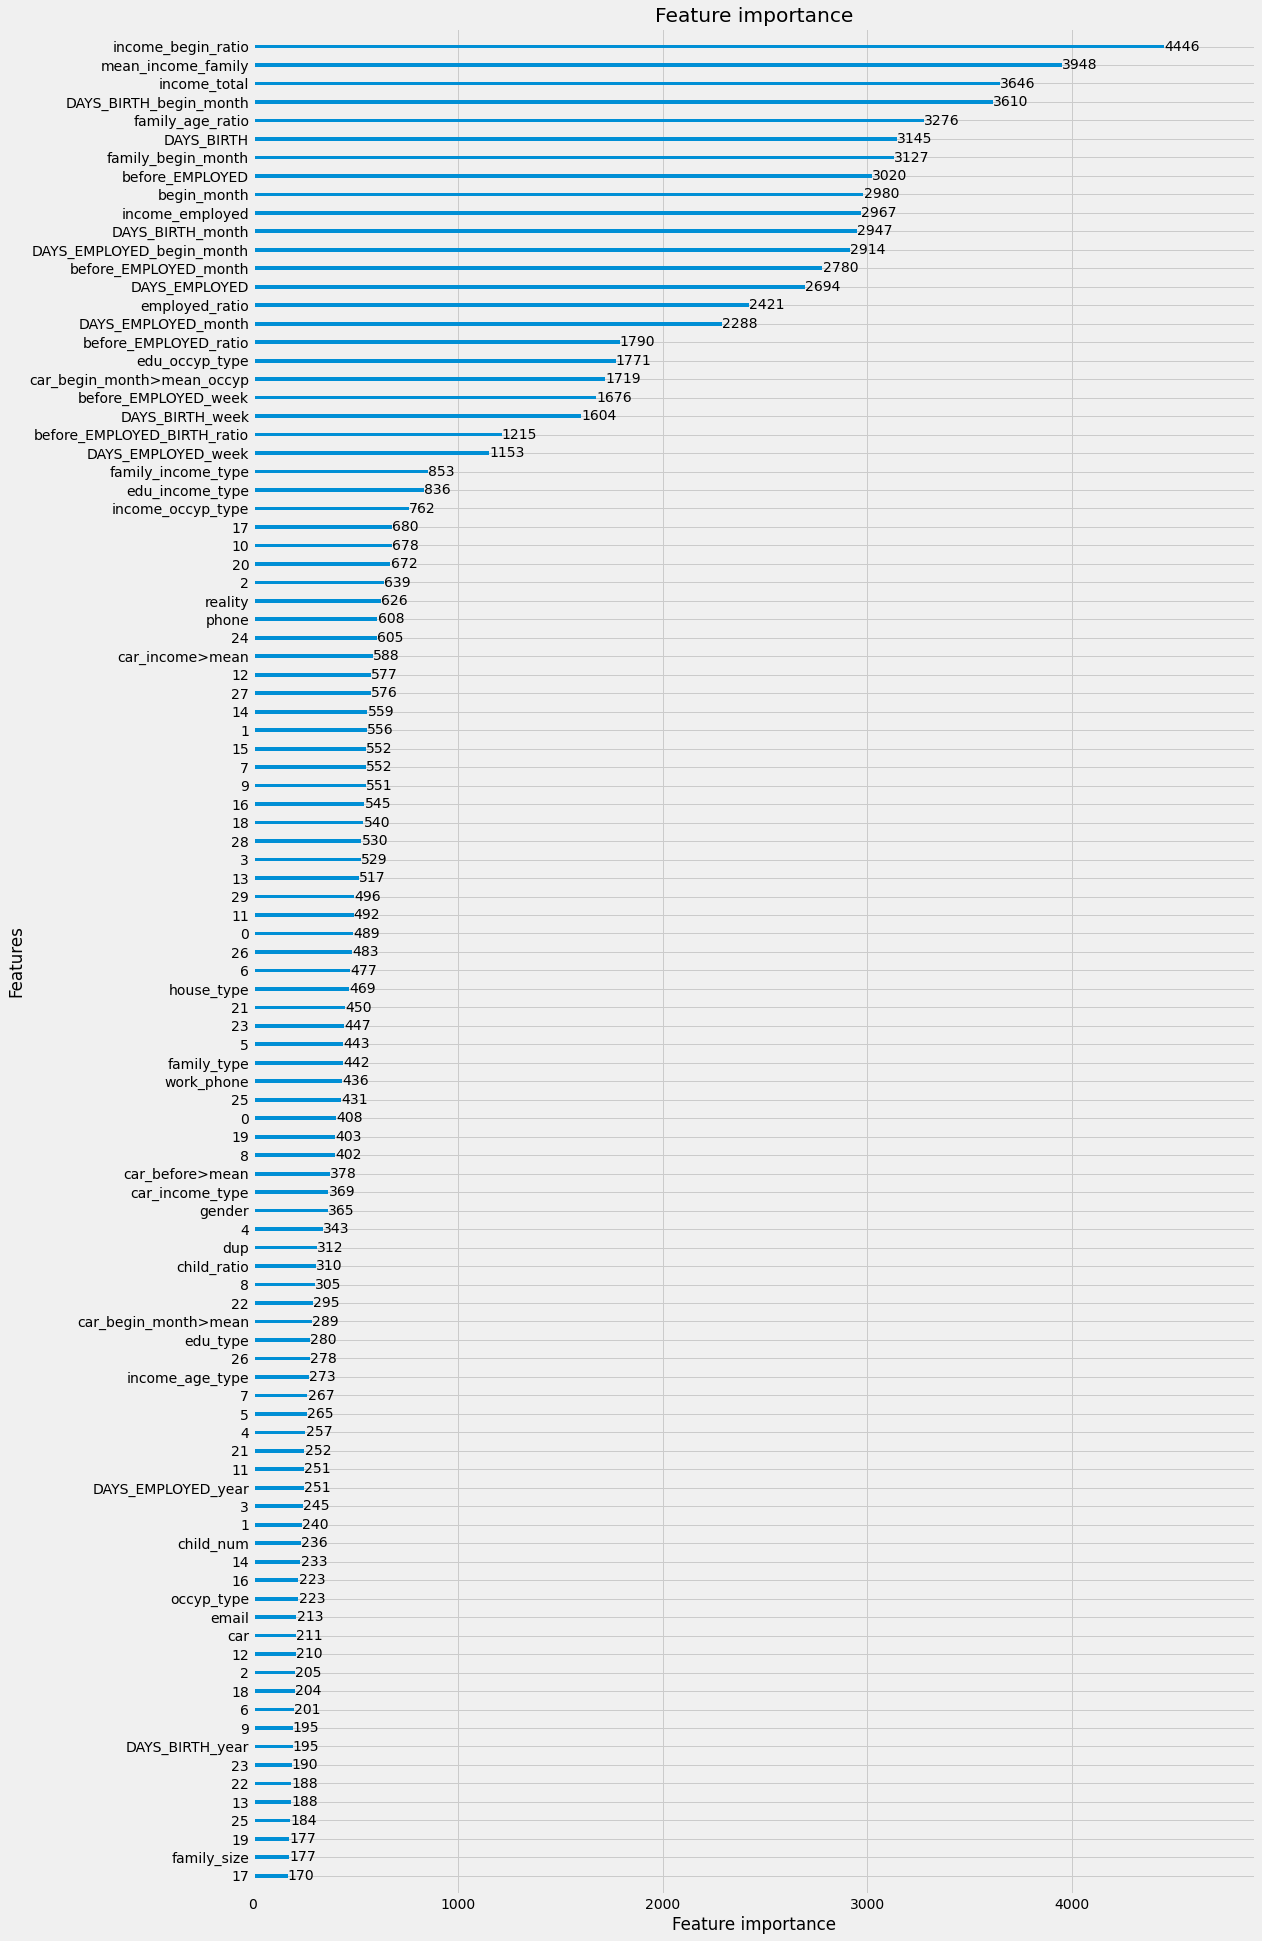

In [117]:
from lightgbm import plot_importance

plot_importance(clf, figsize=(16, 32), max_num_features=100)

#### Feature Selection & Cross Validation

In [63]:
from sklearn.feature_selection import SelectFromModel
smf = SelectFromModel(clf, threshold='median')
smf.fit(ftr, target)
X_new = smf.transform(ftr)
X_te_new = smf.transform(X_tst)
feature_idx = smf.get_support()
feature_name = ftr.columns[feature_idx]

In [64]:
ftr.columns[feature_idx]

Index([                     'gender',                     'reality',
                      'income_total',                 'family_type',
                        'house_type',                  'DAYS_BIRTH',
                     'DAYS_EMPLOYED',                  'work_phone',
                             'phone',                 'begin_month',
                    'employed_ratio',          'mean_income_family',
                   'income_employed',          'income_begin_ratio',
                  'family_age_ratio',          'family_begin_month',
         'DAYS_EMPLOYED_begin_month',      'DAYS_BIRTH_begin_month',
                  'DAYS_BIRTH_month',             'DAYS_BIRTH_week',
               'DAYS_EMPLOYED_month',          'DAYS_EMPLOYED_week',
                   'before_EMPLOYED',       'before_EMPLOYED_month',
              'before_EMPLOYED_week', 'before_EMPLOYED_BIRTH_ratio',
             'before_EMPLOYED_ratio',           'income_occyp_type',
                    'edu_occyp_typ

In [65]:
X_new = pd.DataFrame(X_new)
X_te_new = pd.DataFrame(X_te_new)

X_new.columns = feature_name
X_te_new.columns = feature_name

In [66]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, X_new, target, scoring='neg_log_loss', cv=5)
print('교차 검증별 정확도:', np.round(scores, 4))
print('평균 검증 정확도:', np.round(np.mean(scores), 4))

교차 검증별 정확도: [-0.7275 -0.7323 -0.7347 -0.7371 -0.7326]
평균 검증 정확도: -0.7328


In [68]:
#X_new.to_csv('best_tillnow.csv')
#X_te_new.to_csv('best_tillnow_tst.csv')

#### Bayesian Opt

In [128]:
ftr = X_new
target = y

In [129]:
from bayes_opt import BayesianOptimization

In [130]:
train_x, valid_x, train_y, valid_y = train_test_split(ftr, target, test_size=0.3, random_state=0)
train_x.shape, valid_x.shape

((18519, 60), (7938, 60))

In [131]:
bayesian_params = {
    'max_depth':(8, 16),
    'num_leaves':(24, 64),
    'min_child_samples':(10, 200),
    'min_child_weight':(1, 50),
    'subsample':(0.5, 1),
    'colsample_bytree':(0.5, 1),
    'max_bin':(10, 500),
    'reg_lambda':(0.001, 10),
    'reg_alpha':(0.01, 50)
}

In [132]:
def lgb_log_eval(max_depth, num_leaves, min_child_samples, min_child_weight, subsample, 
                colsample_bytree, max_bin, reg_lambda, reg_alpha):
    
    params = {
        "n_estimators":2000, 
        "learning_rate":0.02,
        'max_depth':int(round(max_depth)),
        'num_leaves':int(round(num_leaves)),
        'min_child_samples': int(round(min_child_samples)),
        'min_child_weight': int(round(min_child_weight)),
        'subsample':max(min(subsample, 1), 0),
        'colsample_bytree':max(min(colsample_bytree, 1), 0),
        'reg_lambda': max(reg_lambda,0),
        'reg_alpha': max(reg_alpha, 0)
    }
    
    lgb_model = LGBMClassifier(**params)
    lgb_model.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric='logloss', verbose=100, 
                early_stopping_rounds=100)
    valid_pred = lgb_model.predict_proba(valid_x)
    log_score = log_loss(valid_y, valid_pred)
    
    return log_score

In [133]:
lgbBO = BayesianOptimization(f=lgb_log_eval, pbounds=bayesian_params, random_state=0)
lgbBO.maximize(init_points=5, n_iter=25)

|   iter    |  target   | colsam... |  max_bin  | max_depth | min_ch... | min_ch... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.798787	valid_1's multi_logloss: 0.807418
[200]	training's multi_logloss: 0.768945	valid_1's multi_logloss: 0.790937
[300]	training's multi_logloss: 0.747585	valid_1's multi_logloss: 0.781943
[400]	training's multi_logloss: 0.730352	valid_1's multi_logloss: 0.775688
[500]	training's multi_logloss: 0.717677	valid_1's multi_logloss: 0.77124
[600]	training's multi_logloss: 0.710302	valid_1's multi_logloss: 0.769272
[700]	training's multi_logloss: 0.705531	valid_1's multi_logloss: 0.768082
[800]	training's multi_logloss: 0.703722	valid_1's multi_logloss: 0.767632
[900]	training's multi_logloss: 0.702873	valid_1's multi_logloss: 0.767

[100]	training's multi_logloss: 0.80914	valid_1's multi_logloss: 0.812282
[200]	training's multi_logloss: 0.789632	valid_1's multi_logloss: 0.799961
[300]	training's multi_logloss: 0.777217	valid_1's multi_logloss: 0.793766
[400]	training's multi_logloss: 0.769551	valid_1's multi_logloss: 0.790179
[500]	training's multi_logloss: 0.766017	valid_1's multi_logloss: 0.788642
[600]	training's multi_logloss: 0.765173	valid_1's multi_logloss: 0.788236
[700]	training's multi_logloss: 0.764686	valid_1's multi_logloss: 0.788038
[800]	training's multi_logloss: 0.764296	valid_1's multi_logloss: 0.787846
[900]	training's multi_logloss: 0.763999	valid_1's multi_logloss: 0.787753
[1000]	training's multi_logloss: 0.76387	valid_1's multi_logloss: 0.787716
[1100]	training's multi_logloss: 0.763854	valid_1's multi_logloss: 0.787702
[1200]	training's multi_logloss: 0.76385	valid_1's multi_logloss: 0.787702
[1300]	training's multi_logloss: 0.763845	valid_1's multi_logloss: 0.7877
[1400]	training's multi_lo

[1500]	training's multi_logloss: 0.794674	valid_1's multi_logloss: 0.800807
[1600]	training's multi_logloss: 0.794674	valid_1's multi_logloss: 0.800807
[1700]	training's multi_logloss: 0.794674	valid_1's multi_logloss: 0.800806
[1800]	training's multi_logloss: 0.794674	valid_1's multi_logloss: 0.800806
[1900]	training's multi_logloss: 0.794674	valid_1's multi_logloss: 0.800806
[2000]	training's multi_logloss: 0.794674	valid_1's multi_logloss: 0.800806
Did not meet early stopping. Best iteration is:
[1998]	training's multi_logloss: 0.794674	valid_1's multi_logloss: 0.800806
|  12       |  0.8008   |  0.6559   |  252.0    |  8.0      |  134.4    |  4.404    |  62.95    |  50.0     |  7.377    |  0.9109   |
Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.810573	valid_1's multi_logloss: 0.812661
[200]	training's multi_logloss: 0.793234	valid_1's multi_logloss: 0.801258
[300]	training's multi_logloss: 0.783138	valid_1's multi_logloss: 0.796175

[1300]	training's multi_logloss: 0.766465	valid_1's multi_logloss: 0.788633
[1400]	training's multi_logloss: 0.76646	valid_1's multi_logloss: 0.788632
[1500]	training's multi_logloss: 0.766456	valid_1's multi_logloss: 0.78863
Early stopping, best iteration is:
[1465]	training's multi_logloss: 0.766456	valid_1's multi_logloss: 0.78863
|  17       |  0.7886   |  0.58     |  306.9    |  14.69    |  142.2    |  20.03    |  32.04    |  32.84    |  3.56     |  0.8835   |
Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.812618	valid_1's multi_logloss: 0.813804
[200]	training's multi_logloss: 0.798475	valid_1's multi_logloss: 0.803903
[300]	training's multi_logloss: 0.793834	valid_1's multi_logloss: 0.801148
[400]	training's multi_logloss: 0.79209	valid_1's multi_logloss: 0.800144
[500]	training's multi_logloss: 0.791064	valid_1's multi_logloss: 0.799563
[600]	training's multi_logloss: 0.790799	valid_1's multi_logloss: 0.799341
[700]	training's mu

[500]	training's multi_logloss: 0.757387	valid_1's multi_logloss: 0.785207
[600]	training's multi_logloss: 0.75628	valid_1's multi_logloss: 0.784702
[700]	training's multi_logloss: 0.755665	valid_1's multi_logloss: 0.784448
[800]	training's multi_logloss: 0.755222	valid_1's multi_logloss: 0.784273
[900]	training's multi_logloss: 0.754997	valid_1's multi_logloss: 0.784197
[1000]	training's multi_logloss: 0.754925	valid_1's multi_logloss: 0.784182
[1100]	training's multi_logloss: 0.754893	valid_1's multi_logloss: 0.784175
[1200]	training's multi_logloss: 0.754873	valid_1's multi_logloss: 0.784172
[1300]	training's multi_logloss: 0.754852	valid_1's multi_logloss: 0.78416
Early stopping, best iteration is:
[1234]	training's multi_logloss: 0.754852	valid_1's multi_logloss: 0.78416
|  22       |  0.7842   |  0.6092   |  317.9    |  12.88    |  144.3    |  21.29    |  34.57    |  29.47    |  4.129    |  0.5096   |
Training until validation scores don't improve for 100 rounds
[100]	training's 

[400]	training's multi_logloss: 0.796857	valid_1's multi_logloss: 0.802371
[500]	training's multi_logloss: 0.795875	valid_1's multi_logloss: 0.801659
[600]	training's multi_logloss: 0.795616	valid_1's multi_logloss: 0.801405
[700]	training's multi_logloss: 0.795415	valid_1's multi_logloss: 0.801203
[800]	training's multi_logloss: 0.795326	valid_1's multi_logloss: 0.801111
[900]	training's multi_logloss: 0.795259	valid_1's multi_logloss: 0.801045
[1000]	training's multi_logloss: 0.795218	valid_1's multi_logloss: 0.801004
[1100]	training's multi_logloss: 0.795192	valid_1's multi_logloss: 0.800977
[1200]	training's multi_logloss: 0.795174	valid_1's multi_logloss: 0.800959
[1300]	training's multi_logloss: 0.795164	valid_1's multi_logloss: 0.800949
[1400]	training's multi_logloss: 0.795158	valid_1's multi_logloss: 0.800942
[1500]	training's multi_logloss: 0.795153	valid_1's multi_logloss: 0.800937
[1600]	training's multi_logloss: 0.79515	valid_1's multi_logloss: 0.800935
[1700]	training's m

In [134]:
lgbBO.res

[{'target': 0.7674654149153005,
  'params': {'colsample_bytree': 0.7744067519636624,
   'max_bin': 360.44278952248555,
   'max_depth': 12.822107008573152,
   'min_child_samples': 113.52780476941041,
   'min_child_weight': 21.75908516760633,
   'num_leaves': 49.835764522666246,
   'reg_alpha': 21.884984691022,
   'reg_lambda': 8.917838234820016,
   'subsample': 0.9818313802505146}},
 {'target': 0.7426629522516105,
  'params': {'colsample_bytree': 0.6917207594128889,
   'max_bin': 397.94526866050563,
   'max_depth': 12.231159358023236,
   'min_child_samples': 117.92846660784714,
   'min_child_weight': 46.35423527634039,
   'num_leaves': 26.841442327915477,
   'reg_alpha': 4.36559369208002,
   'reg_lambda': 0.20316375600581688,
   'subsample': 0.916309922773969}},
 {'target': 0.7375282264728025,
  'params': {'colsample_bytree': 0.8890783754749252,
   'max_bin': 436.30595264094137,
   'max_depth': 15.828946737862111,
   'min_child_samples': 161.8401272011775,
   'min_child_weight': 23.6124

In [135]:
# dictionary에 있는 target값을 모두 추출
target_list = []
for result in lgbBO.res:
    target = result['target']
    target_list.append(target)
print(target_list)
# 가장 큰 target 값을 가지는 순번(index)를 추출
print('minimum target index:', np.argmin(np.array(target_list)))

[0.7674654149153005, 0.7426629522516105, 0.7375282264728025, 0.7800711767501333, 0.7900448020070744, 0.8003940716041866, 0.7876971839702093, 0.7393101850513389, 0.7457323326394358, 0.8007013531405086, 0.7637360380388106, 0.8008061799049954, 0.7929988026356753, 0.7997551377989158, 0.7941791793604598, 0.7912152518632387, 0.7886304919231963, 0.7993299830587726, 0.7916924323786799, 0.7996920980589711, 0.7996920980589711, 0.7841597194518554, 0.7993289290901292, 0.7780682632988181, 0.7995732383178489, 0.8001295845029017, 0.7321683181802943, 0.8009309480038636, 0.800893897393618, 0.800605178403424]
minimum target index: 26


In [136]:
# 가장 큰 target값을 가지는 index값을 기준으로 res에서 해당 parameter 추출. 
min_dict = lgbBO.res[np.argmin(np.array(target_list))]
print(min_dict)

{'target': 0.7321683181802943, 'params': {'colsample_bytree': 1.0, 'max_bin': 12.063552152609525, 'max_depth': 10.93107240990202, 'min_child_samples': 10.0, 'min_child_weight': 1.0, 'num_leaves': 64.0, 'reg_alpha': 0.01, 'reg_lambda': 8.24122472503969, 'subsample': 1.0}}


In [139]:
ftr = X_new
target = y

In [142]:
from sklearn.model_selection import KFold

def train_apps_all_with_oof(ftr, target, nfolds=5):

    # nfolds 개의 cross validatin fold set을 가지는 KFold 생성 
    folds = KFold(n_splits=nfolds, shuffle=True, random_state=0)
    
    # Out of Folds로 학습된 모델의 validation set을 예측하여 결과 확률을 담을 array 생성.
    # validation set가 n_split갯수만큼 있으므로 크기는 ftr_app의 크기가 되어야 함. 
    oof_preds = np.zeros(ftr.shape[0])
    
    # Ouf of Folds로 학습된 모델의 test dataset을 예측하여 결과 확률을 담을 array 생성. 
    test_preds = np.zeros((X_te_new.shape[0], 3))
    
    # n_estimators를 4000까지 확대. 
    clf = LGBMClassifier(
                n_jobs=4,
                n_estimators=4000,
                learning_rate=0.01,
                max_depth=11,
                num_leaves=64,
                colsample_bytree=1.0,
                subsample=1.0,
                max_bin=120,
                reg_alpha=0.01,
                reg_lambda=8.24,
                min_child_weight=1.0,
                min_child_samples=10,
                silent=-1,
                verbose=-1,
                )
    
    # nfolds 번 cross validation Iteration 반복하면서 OOF 방식으로 학습 및 테스트 데이터 예측
    for fold_idx, (train_idx, valid_idx) in enumerate(folds.split(ftr)):
        print('##### iteration', fold_idx, '시작')
        # 학습용 데이터 세트의 인덱스와 검증용 데이터 세트의 인덱스 추출하여 이를 기반으로 학습/검증 데이터 추출
        train_x = ftr.iloc[train_idx, :]
        train_y = target.iloc[train_idx]
        valid_x = ftr.iloc[valid_idx, :]
        valid_y = target.iloc[valid_idx]
        
        # 추출된 학습/검증 데이터 세트로 모델 학습. early_stopping은 200으로 증가. 
        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'logloss', verbose= 200, 
                early_stopping_rounds= 200)
        
        # 검증 데이터 세트로 예측된 확률 저장. 사용되지는 않음. 
        #oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]    
        
        # 학습된 모델로 테스트 데이터 세트에 예측 확률 계산.
        # nfolds 번 반복 실행하므로 평균 확률을 구하기 위해 개별 수행시 마다 수행 횟수로 나눈 확률을 추후에 더해서 최종 평균 확률 계산. 
        test_preds += clf.predict_proba(X_te_new, num_iteration=clf.best_iteration_)/folds.n_splits
             
    return clf, test_preds

In [143]:
clf, test_preds = train_apps_all_with_oof(ftr, target, nfolds=5)

##### iteration 0 시작
Training until validation scores don't improve for 200 rounds
[200]	training's multi_logloss: 0.737061	valid_1's multi_logloss: 0.783979
[400]	training's multi_logloss: 0.679015	valid_1's multi_logloss: 0.760223
[600]	training's multi_logloss: 0.638998	valid_1's multi_logloss: 0.748925
[800]	training's multi_logloss: 0.607038	valid_1's multi_logloss: 0.741421
[1000]	training's multi_logloss: 0.579225	valid_1's multi_logloss: 0.735738
[1200]	training's multi_logloss: 0.552855	valid_1's multi_logloss: 0.732059
[1400]	training's multi_logloss: 0.528736	valid_1's multi_logloss: 0.729329
[1600]	training's multi_logloss: 0.507459	valid_1's multi_logloss: 0.729164
[1800]	training's multi_logloss: 0.487977	valid_1's multi_logloss: 0.728525
[2000]	training's multi_logloss: 0.46978	valid_1's multi_logloss: 0.728573
Early stopping, best iteration is:
[1889]	training's multi_logloss: 0.480077	valid_1's multi_logloss: 0.728277
##### iteration 1 시작
Training until validation scor

In [144]:
sub[sub.columns] = test_preds
sub.head()

,0,1,2
index,,,
26457,0.056758,0.155724,0.787518
26458,0.214872,0.193652,0.591476
26459,0.033749,0.084137,0.882114
26460,0.079132,0.132665,0.788203
26461,0.116534,0.155295,0.728171


In [146]:
sub.to_csv('0519best+feature.csv')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

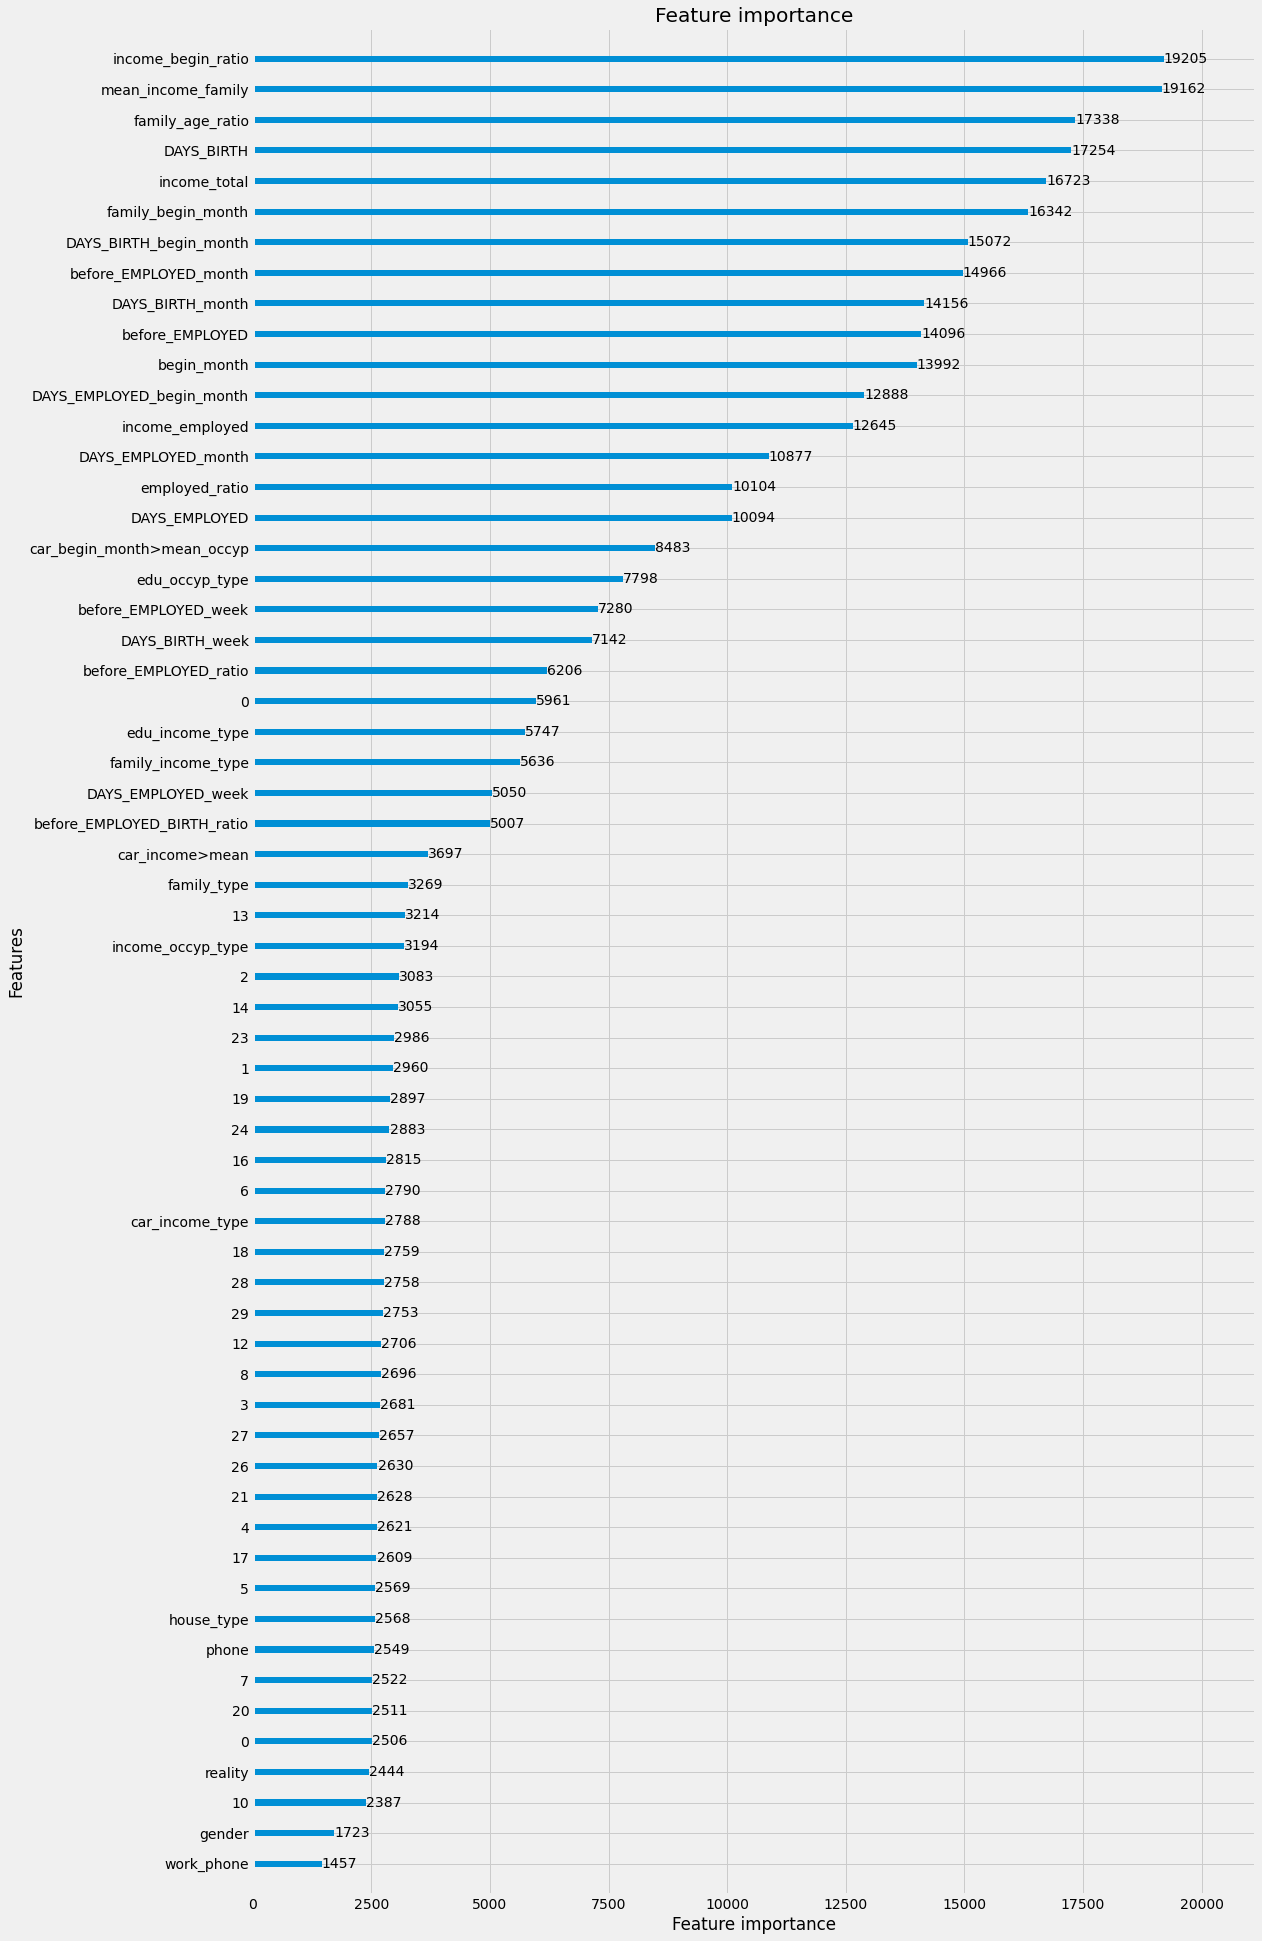

In [145]:
from lightgbm import plot_importance

plot_importance(clf, figsize=(16, 32), max_num_features=100)

In [67]:
X = X_new

In [68]:
#n_est = 1000
seed = 42
n_fold = 5
n_class = 3

lgb_params = {
    'metric': 'multi_logloss',
    'n_estimators': 4000,
    'objective': 'multiclass',
    'random_state': seed,
    'learning_rate': 0.01,
    'min_child_samples': 20,
    'reg_alpha': 3e-5,
    'reg_lambda': 9e-2,
    'num_leaves': 63,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'num_class': n_class
}

xgb_params = {
    'metric': 'mlogloss',
    'objective': 'multi:softprob',
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'learning_rate': 0.01,
    'random_state': seed,
    'num_class': n_class,
    'max_depth': 6,
    'n_estimators': 2000,
    'min_child_samples': 20,
    'reg_alpha': 3e-5,
    'reg_lambda': 9e-2,
}

rf_params = {
    'max_depth': 15,
    'min_samples_leaf': 8,
    'random_state': seed
}

In [69]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier


base_models = {'rf': RandomForestClassifier(**rf_params), 
               'lgb': LGBMClassifier(**lgb_params),
               'xgb': XGBClassifier(),
               'et': ExtraTreesClassifier(bootstrap=True, 
                                          criterion='entropy', 
                                          max_features=0.55, 
                                          min_samples_leaf=8, 
                                          min_samples_split=4, 
                                          n_estimators=100)}

In [70]:
from copy import copy

X = X_new
y = trn[target_col]
X_tst = X_te_new

cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

p_dict = {}
p_tst_dict = {}
for name in base_models:
    print(f'Training {name}:')
    p = np.zeros((X.shape[0], n_class), dtype=float)
    p_tst = np.zeros((X_tst.shape[0], n_class), dtype=float)
    for i, (i_trn, i_val) in enumerate(cv.split(X, y)):
        clf = copy(base_models[name])
        clf.fit(X.iloc[i_trn], y[i_trn])

        p[i_val] = clf.predict_proba(X.iloc[i_val])
        p_tst += clf.predict_proba(X_tst) / n_fold

    p_dict[name] = p
    p_tst_dict[name] = p_tst
    print(f'\tCV Log Loss: {log_loss(y, p):.6f}')

Training rf:


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
X = pd.DataFrame(np.hstack([x for _, x in p_dict.items()]))
X_tst = pd.DataFrame(np.hstack([x for _, x in p_tst_dict.items()]))

p = np.zeros((X.shape[0], n_class), dtype=float)
p_tst = np.zeros((X_tst.shape[0], n_class), dtype=float)
for i_cv, (i_trn, i_val) in enumerate(cv.split(X, y)):
    if i_cv == 0:
        clf = AutoLGB(objective='multiclass', metric='multi_logloss', params={'num_class': n_class}, 
                      feature_selection=False, n_est=10000)
        clf.tune(X.iloc[i_trn], y[i_trn])
        n_best = clf.n_best
        features = clf.features
        params = clf.params
        print(f'best iteration: {n_best}')
        print(f'selected features ({len(features)}): {features}')        
        pprint(params)
        clf.fit(X.iloc[i_trn], y[i_trn])
    else:
        train_data = lgb.Dataset(X[features].iloc[i_trn], label=y[i_trn])
        clf = lgb.train(params, train_data, n_best, verbose_eval=100)
    
    p[i_val] = clf.predict(X[features].iloc[i_val])
    p_tst += clf.predict(X_tst[features]) / n_fold

In [ ]:
print(f'CV Log Loss: {log_loss(y, p):.6f}')
np.savetxt(predict_val_file, p, fmt='%.6f')
np.savetxt(predict_tst_file, p_tst, fmt='%.6f')

In [ ]:
sub[sub.columns] = p_tst
sub.head()

In [ ]:
sub.to_csv(submission_file)